In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [49]:
%matplotlib inline
import sys,os
import csv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [15]:
maxfile = 'metop_rad_belt_passes_max.csv'
print(os.path.exists(maxfile))
minfile = 'metop_rad_belt_passes_min.csv'
print(os.path.exists(maxfile))
medfile = 'metop_rad_belt_passes_median.csv'
print(os.path.exists(maxfile))

True
True
True


In [35]:
maxset = pd.read_csv(maxfile).add_prefix('max_')
minset = pd.read_csv(minfile).add_prefix('min_')
medset = pd.read_csv(medfile).add_prefix('med_')

raw = pd.concat([maxset, minset, medset], axis=1)
print(raw.columns)

Index(['max_dateTime', 'max_Kp', 'max_Dst', 'max_dens', 'max_velo', 'max_Pdyn',
       'max_ByIMF', 'max_BzIMF', 'max_mep06', 'max_mep05', 'max_mep01',
       'max_me03', 'max_Lval', 'max_mlt', 'max_lat', 'max_lon', 'min_dateTime',
       'min_Kp', 'min_Dst', 'min_dens', 'min_velo', 'min_Pdyn', 'min_ByIMF',
       'min_BzIMF', 'min_mep06', 'min_mep05', 'min_mep01', 'min_me03',
       'min_Lval', 'min_mlt', 'min_lat', 'min_lon', 'med_dateTime', 'med_Kp',
       'med_Dst', 'med_dens', 'med_velo', 'med_Pdyn', 'med_ByIMF', 'med_BzIMF',
       'med_mep06', 'med_mep05', 'med_mep01', 'med_me03', 'med_Lval',
       'med_mlt', 'med_lat', 'med_lon'],
      dtype='object')


In [36]:
drop_cols = ['max_dateTime', 'min_dateTime', 'med_dateTime']
raw = raw.drop(drop_cols, axis=1)
print(len(raw.columns))
print(raw.describe())

45
           max_Kp     max_Dst    max_dens    max_velo    max_Pdyn   max_ByIMF  \
count  947.000000  947.000000  947.000000  947.000000  947.000000  947.000000   
mean     2.151420  -31.430864    4.754871  515.196190    2.133664    0.457167   
std      1.541516   17.441217    3.379340  138.878535    1.421048    2.539781   
min      0.000000 -158.622133    0.434679  293.621418    0.511386  -12.184434   
25%      0.700000  -40.472563    2.400000  366.057078    1.321697   -1.288006   
50%      2.300000  -31.279383    3.491533  553.868227    1.834693    0.500000   
75%      3.300000  -17.350393    6.314319  631.889484    2.630729    2.054407   
max      8.300000    1.563935   16.759011  951.608129   21.417958   10.490805   

        max_BzIMF   max_mep06  max_mep05     max_mep01  ...   med_ByIMF  \
count  947.000000  947.000000      947.0    947.000000  ...  947.000000   
mean    -0.189605    1.529963        0.0   1872.038213  ...    0.457167   
std      2.084481    1.895660        0.0  

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(raw.drop(['max_mep06'],axis=1), 
                 raw.max_mep06, test_size=0.2, random_state=43)

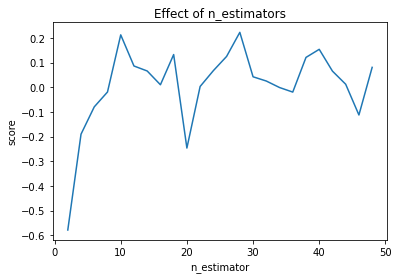

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

estimators = np.arange(2, 50, 2)
scores = []
mae = []
mse = []
rf = RandomForestRegressor(n_jobs=-1)

for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))

plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("test score")
plt.plot(estimators, scores)

In [69]:
from sklearn.base import clone 
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(X_train.columns, importances)
    return importances_df

In [70]:
importance_df = drop_col_feat_imp(rf, X_train, y_train)

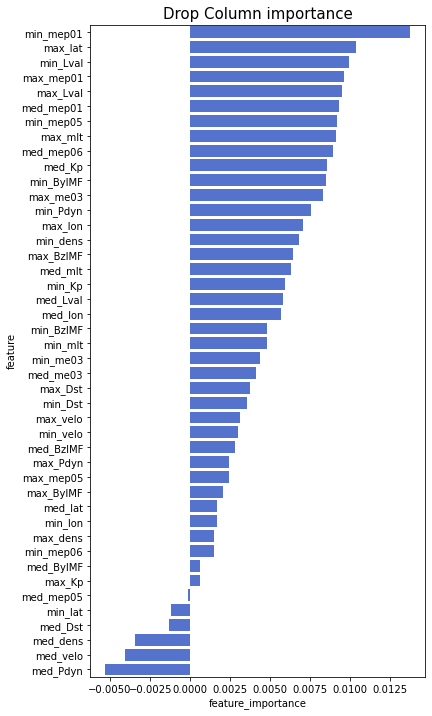

In [71]:
import seaborn as sns
# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 15)
plt.figure(figsize=(6,12))
var_imp_plot(importance_df, 'Drop Column importance')

In [74]:
sel_cols = importance_df.feature[:10].values
print(sel_cols)

['min_mep01' 'max_lat' 'min_Lval' 'max_mep01' 'max_Lval' 'med_mep01'
 'min_mep05' 'max_mlt' 'med_mep06' 'med_Kp']


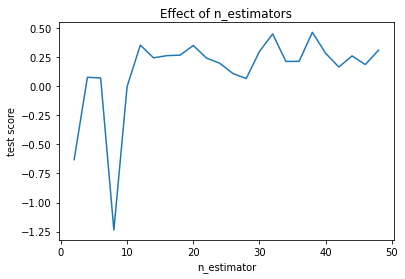

In [75]:
# re-train model with top 10 features
X_train, X_test, y_train, y_test = train_test_split(raw[sel_cols], 
                 raw.max_mep06, test_size=0.2, random_state=43)

estimators = np.arange(2, 50, 2)
scores = []
rf = RandomForestRegressor(n_jobs=-1)

for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(X_train, y_train)
    scores.append(rf.score(X_test, y_test))

plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("test score")
plt.plot(estimators, scores)

In [78]:
print(max(scores))

0.46172828523590637
